# Polarimetric coherence

Copyright 2025 European Space Agency (ESA)

Licensed under  ESA Software Community License Permissive (Type 3) – v2.4

## Setup 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### Prerequisities

In [3]:
import pathlib

import numpy as np
from matplotlib import pyplot as plt

In [4]:
import bioqlk

In [5]:
import inspect
import IPython.display

### Read image
Import image and read channels.

In [6]:
basepath = pathlib.Path(
    "~/data/biomass/first-image/SLCs/BIO_S1_SCS__1S_20250523T102350_20250523T102542_C_G___M___C___T____F001_01_D9LNTL"
    # "~/data/biomass/first-image/SLCs/TEST/BIO_S1_SCS__1S_20250523T094034_20250523T094052_C_G___M___C___T____F001_01_D9N91K"
).expanduser()

### Image processing parameters

In [7]:
kernel_size = [7, 7]
ph_corrections = [
    0, -0.19090325385332108, 1.3020425736904144, 1.1111393198370934
]

## Step 1: Compute Complex Signal from Amplitude and Phase with polar coordinates (a, phi)

In [8]:
IPython.display.Code(inspect.getsource(bioqlk.load_data), language="python")

def load_data(product_path: str, *, return_metadata: bool = False):
    """Load data from a BIOMASS products.

    Limitations:
    * currently only works for L1A products (4 polarimetric channels).

    Parameters
    ----------

    product_path : str
        path to the BIOMASS product (folder)
    return_metadata : bool
        return metadata and GCPs in addition to the 4 polarizations
    """

    basepath = pathlib.Path(product_path)

    try:
        file_path = _first(basepath.glob("measurement/bio_s1_scs__1s_*_i.vrt"))
    except ValueError:
        raise FileNotFoundError(
            f"unable to find 'bio_s1_scs__1s_*_i.vrt' in "
            f"{basepath / 'measurement'}"
        )

    with rio.open(file_path) as src:
        data = src.read()
        metadata = src.meta.copy()
        gcps = src.get_gcps()

    hh, hv, vh, vv = data

    if return_metadata:
        return hh, hv, vh, vv, metadata, gcps
    else:
        return hh, hv, vh, vv

In [9]:
hh, hv, vh, vv, meta, gcps = bioqlk.load_data(basepath, return_metadata=True)

In [10]:
IPython.display.Code(inspect.getsource(bioqlk.fix_ical_phase), language="python")

def fix_ical_phase(hh, hv, vh, vv, pc_hh, pc_hv, pc_vh, pc_vv=0.0):
    """Correct phase imbalances between polarimetric channels.

    pc_hh, pc_hv, pc_vh and pc_vv are phase corrections expressed in radians.
    """
    hh_out = hh * np.exp(1j * pc_hh)
    hv_out = hv * np.exp(1j * pc_hv)
    vh_out = vh * np.exp(1j * pc_vh)
    vv_out = vv * np.exp(1j * pc_vv)

    return hh_out, hv_out, vh_out, vv_out

In [11]:
hh, hv, vh, vv = bioqlk.fix_ical_phase(hh, hv, vh, vv, *ph_corrections)

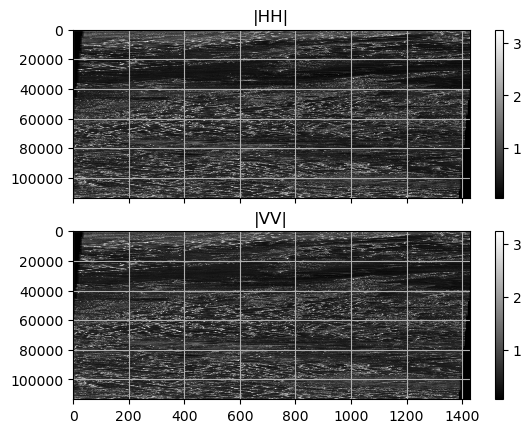

In [12]:
threshold = 0.03

fig, ax = plt.subplots(2, sharex=True)

hh_abs = np.abs(hh)
vmin, vmax = bioqlk.quantile_scaling(hh_abs, threshold=threshold)
img = ax[0].imshow(
    hh_abs, vmin=vmin, vmax=vmax, label="hh", aspect="auto", cmap="gray"
    )
ax[0].grid()
# ax[0].legend()
ax[0].set_title("|HH|")
fig.colorbar(img, ax=ax[0])

vv_abs = np.abs(vv)
vmin, vmax = bioqlk.quantile_scaling(vv_abs, threshold=threshold)
ax[1].imshow(
    vv_abs, vmin=vmin, vmax=vmax,label="vv", aspect="auto", cmap="gray"
)
ax[1].grid()
# ax[1].legend()
ax[1].set_title("|VV|")
fig.colorbar(img, ax=ax[1]);

## Step 2: polarimetric coherence computation (between co-pol)

In [13]:
IPython.display.Code(inspect.getsource(bioqlk.cpx_coherence), language="python")

def cpx_coherence(
    d1: np.ndarray,
    d2: np.ndarray,
    phase: np.ndarray | None = None,
    kernel_size: int | tuple[int, int] = (15, 3),
) -> np.ndarray:
    """Coherence computation.

    Parameters
    ----------
    d1 : np.ndarray
        first data channel
    d2 : np.ndarray
        second data channel
    phase : np.ndarray | None
        optional correction phase in radians
    kernel_size : int | tuple[int, int], optional
        size of the boxcar filter, if a single integer is provided, then the
        the same size is assume d for both dimensions of teh filter kernel.

    Returns
    -------
    np.ndarray
        coherence array
    """
    num = d1 * d2.conj()
    if phase is not None:
        assert d1.shape == phase.shape
        num = num * np.exp(1j * phase)
    num = ndimage.uniform_filter(
        num, size=kernel_size, mode="constant", cval=0.0
    )
    den1 = ndimage.uniform_filter(
        np.abs(d1) ** 2, size=kernel_size, mode="constant", cval=0.0
    )
    den2 = ndimage.uniform_filter(
        np.abs(d2) ** 2, size=kernel_size, mode="constant", cval=0.0
    )

    coherence = np.ma.masked_invalid(num / np.sqrt(den1 * den2))
    coherence = np.ma.masked_where(np.abs(coherence) > 1, coherence)

    return coherence

In [14]:
coh = bioqlk.cpx_coherence(hh, vv)

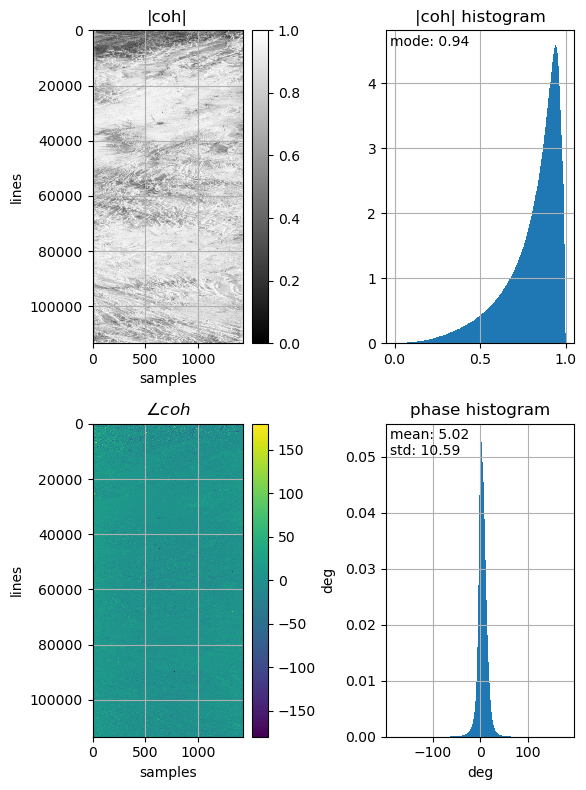

In [34]:
fig, ax = plt.subplots(2, 2, figsize=[6, 8])

coh_abs = np.abs(coh)
coh_ph = np.rad2deg(np.angle(coh))

img = ax[0, 0].imshow(coh_abs, vmin=0, vmax=1, aspect="auto", cmap="gray")
ax[0, 0].grid()
ax[0, 0].set_xlabel("samples")
ax[0, 0].set_ylabel("lines")
ax[0, 0].set_title("|coh|")
fig.colorbar(img, ax=ax[0, 0])

h, b, _ = ax[0, 1].hist(coh_abs.ravel(), bins=500, density=True, label="|coh|", range=[0, 1])
ax[0, 1].grid()
ax[0, 1].set_title("|coh| histogram")
b = (b[:-1] + b[1:]) / 2
mode = b[np.argmax(h)]
ax[0, 1].text(0.02, 0.95, f"mode: {mode:.02f}", transform=ax[0, 1].transAxes)

img = ax[1, 0].imshow(coh_ph, aspect="auto", interpolation="nearest")
ax[1, 0].grid()
ax[1, 0].set_xlabel("samples")
ax[1, 0].set_ylabel("lines")
ax[1, 0].set_title(r"$\angle coh$")
cb = fig.colorbar(img, ax=ax[1, 0])
cb.set_label("deg")

ax[1, 1].hist(coh_ph.ravel(), bins=500, density=True, label="angle(coh)", range=[-180, +180])
ax[1, 1].grid()
ax[1, 1].set_xlabel("deg")
ax[1, 1].set_title("phase histogram")

mean = coh_ph.mean()
std = coh_ph.std()

ax[1, 1].text(0.02, 0.95, f"mean: {mean:.02f}", transform=ax[1, 1].transAxes)
ax[1, 1].text(0.02, 0.90, f"std: {std:.02f}", transform=ax[1, 1].transAxes)

plt.tight_layout()

In [16]:
coh2 = bioqlk.cpx_coherence(hh, hv)

In [ ]:
fig, ax = plt.subplots(2, 2)

coh_abs = np.abs(coh2)
coh_ph = np.angle(coh2)

img = ax[0, 0].imshow(coh_abs, vmin=0, vmax=1, aspect="auto", cmap="gray")
ax[0, 0].grid()
ax[0, 0].set_title("|coh|")
fig.colorbar(img, ax=ax[0, 0])

img = ax[0, 1].imshow(coh_ph, aspect="auto", interpolation="nearest")
ax[0, 1].grid()
ax[0, 1].set_title("angle(coh)")
fig.colorbar(img, ax=ax[0, 1])

ax[1, 0].hist(coh_abs.ravel(), bins=500, density=True, label="|coh|", range=[0, 1])
ax[1, 0].grid()

ax[1, 1].hist(coh_ph.ravel(), bins=500, density=True, label="angle(coh)", range=[-np.pi, +np.pi])
ax[1, 1].grid()

plt.tight_layout()